In [85]:
from lightfm import LightFM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Objective

The goal is to develop a model to predict the movies that a user might like based on collaborative filtering.

# load data

In [86]:
# load data
ratings = pd.read_csv('input/ratings.csv')
movies = pd.read_csv('input/movies.csv')

# EDA

## Ratings dataset

In [87]:
ratings.shape

(100836, 4)

In [88]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


- How many users have we got?
- How many movies?
- What is the best ranked movie?

In [89]:
ratings.userId.nunique(), ratings.movieId.nunique()

(610, 9724)

`Ratings` dataset contains 610 users and 9724 ranked movies

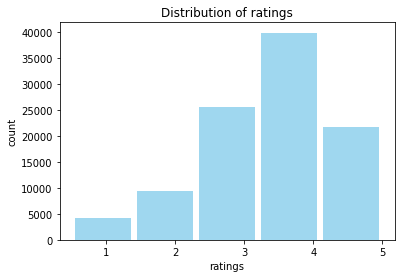

In [90]:
plt.figure()
plt.hist(ratings.rating, rwidth=.9, bins=5, alpha=.8, color='skyblue')
plt.title('Distribution of ratings')
plt.xlabel('ratings')
plt.ylabel('count')
plt.show()

Let's have a look on `movies` dataset  

In [91]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [92]:
movies.shape

(9742, 3)

In [93]:
movies.movieId.nunique()

9742

18 movies are not ranked in ranking dataset, let's find out which movies are they

In [94]:
movies[~movies.movieId.isin(ratings.movieId)]

,movieId,title,genres
816,1076,"Innocents, The (1961)",Drama|Horror|Thriller
2211,2939,Niagara (1953),Drama|Thriller
2499,3338,For All Mankind (1989),Documentary
2587,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama
3118,4194,I Know Where I'm Going! (1945),Drama|Romance|War
4037,5721,"Chosen, The (1981)",Drama
4506,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama|Romance
4598,6849,Scrooge (1970),Drama|Fantasy|Musical
4704,7020,Proof (1991),Comedy|Drama|Romance
5020,7792,"Parallax View, The (1974)",Thriller


No user has interacted whatsoever with the movies above, that's way we have no records about them in ratings table. The user could have watched the movie but has not submitted any rating.

## Top 10 movies

In [95]:
# best ranked movies
best_ranking = ratings.groupby('movieId')[['rating']].mean()
best_ranking['nbr_voters'] = ratings.groupby('movieId')[['userId']].count()
best_ranking = best_ranking.sort_values(by='nbr_voters', ascending=False)[:10]
best_ranking['movie_title'] = movies[movies.movieId.isin(best_ranking.index)].set_index('movieId').title
best_ranking

,rating,nbr_voters,movie_title
movieId,,,
356,4.164134,329,Forrest Gump (1994)
318,4.429022,317,"Shawshank Redemption, The (1994)"
296,4.197068,307,Pulp Fiction (1994)
593,4.161290,279,"Silence of the Lambs, The (1991)"
2571,4.192446,278,"Matrix, The (1999)"
260,4.231076,251,Star Wars: Episode IV - A New Hope (1977)
480,3.750000,238,Jurassic Park (1993)
110,4.031646,237,Braveheart (1995)
589,3.970982,224,Terminator 2: Judgment Day (1991)


## Movies per category

In [96]:
categories_dict = {}
for idx, value in movies.genres.items():
    categories = value.split('|')
    for category in categories:
        categories_dict[category] = categories_dict.get(category, 0) + 1

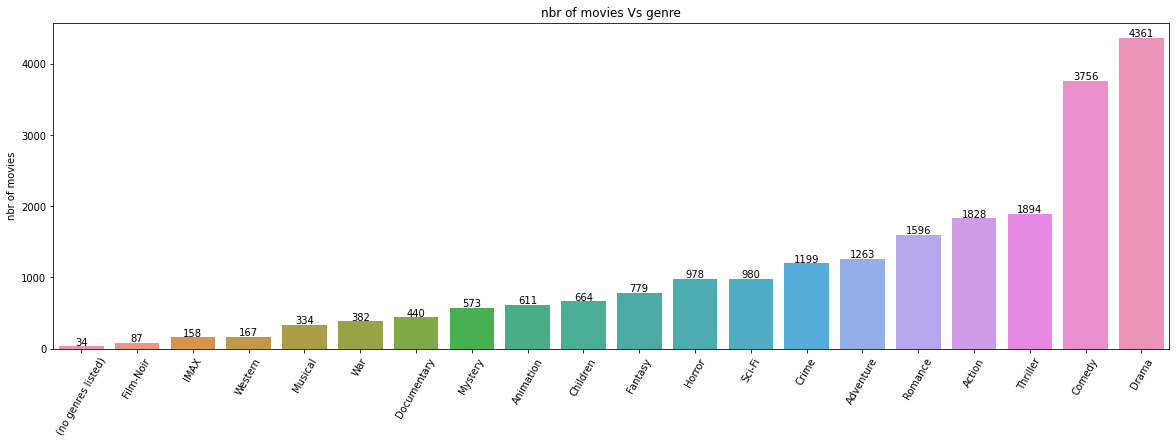

In [97]:
categories_dict_sorted = {k: v for k, v in sorted(categories_dict.items(), key=lambda item: item[1])}
plt.figure(figsize=(20,6))
ax = plt.axes()
sns.barplot(x=list(categories_dict_sorted.keys()), y=list(categories_dict_sorted.values()), ax=ax)
plt.xticks(rotation=60)
plt.ylabel('nbr of movies')
plt.title('nbr of movies Vs genre')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+20,
            f'{int(height)}',
            ha="center", fontsize=10)

plt.show()

# Recommendation system

To build the recommendation system, we will use LightFM model. 

LightFM is a Python implementation of a number of popular recommendation algorithms for both implicit and explicit feedback.

It also makes it possible to incorporate both item and user metadata into the traditional matrix factorization algorithms. It represents each user and item as the sum of the latent representations of their features, thus allowing recommendations to generalise to new items (via item features) and to new users (via user features).

You will find the documentation here: https://making.lyst.com/lightfm/docs/home.html

In [98]:
n_rows = ratings['userId'].unique().shape[0]
n_cols = ratings['movieId'].unique().shape[0]
sparsity = float(ratings.shape[0]) / float(n_rows*n_cols)
print(f'Number of users: {n_rows}')
print(f'Number of movies: {n_cols}')
print(f'Sparsity: {sparsity:.2%}')

Number of users: 610
Number of movies: 9724
Sparsity: 1.70%


This means that our interaction matrix is highly sparse since only 1.7% of values are none zero.
Let's try to make our interaction matrix less sparse. We have some options for that:
- keep users that have interacted with a minimum numbers of movies.
- keep movies that have been rated by a minimum number of users.

Note: from the EDA we saw that a user can vote only once for a given movie which makes sense :)

In [99]:
min_nbr_ratings_per_movie = 2
min_nbr_of_rated_movies_by_usr = 4
ratings_filtered = ratings.copy()

n_rows = ratings_filtered['userId'].unique().shape[0]
n_cols = ratings_filtered['movieId'].unique().shape[0]
sparsity = float(ratings_filtered.shape[0]) / float(n_rows*n_cols)

print('Evaluate interaction matrix sparsity before optimization')
print(f'Number of users: {n_rows}')
print(f'Number of movies: {n_cols}')
print(f'Sparsity: {sparsity:.2%}')

# filter movies that do not match our criterion
count_movies_vs_usr = ratings_filtered.groupby(['movieId'])['userId'].count()
movieID_to_drop = count_movies_vs_usr[count_movies_vs_usr<min_nbr_ratings_per_movie].index.to_list()
print(f'{len(movieID_to_drop)} movies have been dropped')
ratings_filtered = ratings_filtered[~ratings_filtered.movieId.isin(movieID_to_drop)]

# filter users that do not match our criterion
count_user_vs_movies = ratings_filtered.groupby(['userId'])['movieId'].count()
userId_to_drop = count_user_vs_movies[count_user_vs_movies<min_nbr_of_rated_movies_by_usr].index.to_list()
print(f'{len(userId_to_drop)} users have been dropped')
ratings_filtered = ratings_filtered[~ratings_filtered.userId.isin(userId_to_drop)]

print('\nEvaluate interaction matrix sparsity after optimization')
n_rows = ratings_filtered['userId'].unique().shape[0]
n_cols = ratings_filtered['movieId'].unique().shape[0]
sparsity = float(ratings_filtered.shape[0]) / float(n_rows*n_cols)
print(f'Number of users: {n_rows}')
print(f'Number of movies: {n_cols}')
print(f'Sparsity: {sparsity:.2%}')

Evaluate interaction matrix sparsity before optimization
Number of users: 610
Number of movies: 9724
Sparsity: 1.70%
3446 movies have been dropped
0 users have been dropped

Evaluate interaction matrix sparsity after optimization
Number of users: 610
Number of movies: 6278
Sparsity: 2.54%


Our algorithme has filtered movie that do not have more then 2 interactions with users. As a results the number of movies dropped from 9724 movies to 6278. 

Now that we have optimized our matrix sparsity let's convert it from dense to sparse format as LightFM model expects the dataset to be a sparse matrix.

In [100]:
# let's construct our (n_users x n_movies) matrix

# Create mappings
rid_to_idx = {}
idx_to_rid = {}
for (idx, rid) in enumerate(ratings_filtered['userId'].unique().tolist()):
    rid_to_idx[rid] = idx
    idx_to_rid[idx] = rid

cid_to_idx = {}
idx_to_cid = {}
for (idx, cid) in enumerate(ratings_filtered['movieId'].unique().tolist()):
    cid_to_idx[cid] = idx
    idx_to_cid[idx] = cid

In [101]:
import scipy.sparse as sparse

def map_ids(row, mapper):
    return mapper[row]

userId = ratings_filtered['userId'].apply(map_ids, args=[rid_to_idx]).values
movieId = ratings_filtered['movieId'].apply(map_ids, args=[cid_to_idx]).values
#V = np.ones(userId.shape[0])
V = ratings_filtered.rating
interaction_matrix = sparse.coo_matrix((V, (userId, movieId)), dtype=np.float64)
interaction_matrix = interaction_matrix.tocsr()

This basically tells sparse matrix the coordinates of the non zero values. In our case when ever there is an interaction between a user and a moive we put 1

## Interaction matrix

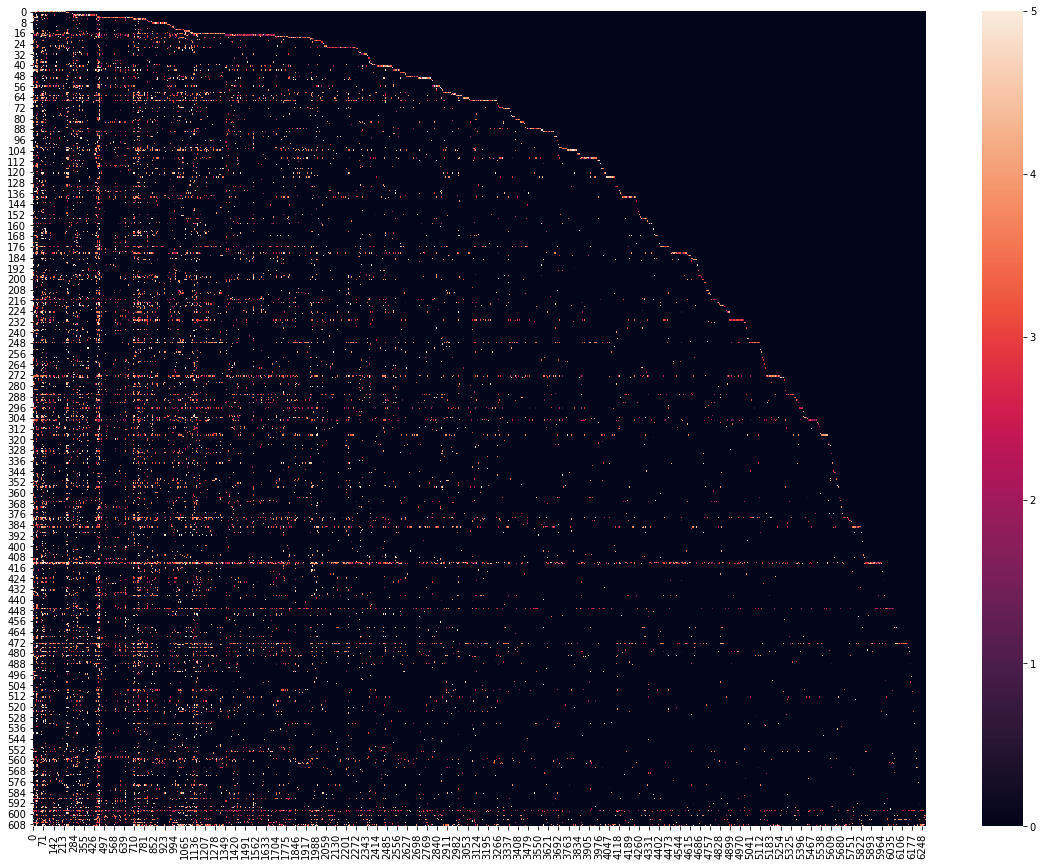

In [102]:
# our interaction matrix looks like this
plt.figure(figsize=(20, 15))
sns.heatmap(interaction_matrix.toarray(), cbar=True)
plt.show()

As you see most of our interaction matrix is composed of zeros. Only 2.54% of its elements are none zeros values. That's why it is import to convert to sparse format using scipy as we did to make it more memory friendly and efficient in termes of calculations.

In [103]:
# check top 10 movies if they have lots of interactions

# Modeling

We will use collaborative filtering using matrix factorization approach based on SVD. 

In [123]:
from lightfm import cross_validation

train, test = cross_validation.random_train_test_split(interaction_matrix, test_percentage=.2,
                                                       random_state=np.random.RandomState(seed=12))

In [124]:
test, train

(<610x6278 sparse matrix of type '<class 'numpy.float64'>'
 	with 19478 stored elements in COOrdinate format>,
 <610x6278 sparse matrix of type '<class 'numpy.float64'>'
 	with 77912 stored elements in COOrdinate format>)

We will use 77912 interaction to train our model, and 19478 interactions for the testing set

In [147]:
# instanciate
import time

import numpy as np

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score


num_components = 30
k=15

model = LightFM(no_components=num_components,
                loss='warp',
                k=k)


model.fit(train, epochs=30, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


## Evaluation

In [148]:
from lightfm.evaluation import precision_at_k
f"Precision @k=10 train : {precision_at_k(model, test, train_interactions=train).mean():.2%}"

'Precision @k=10 train : 23.89%'

Precision at K is very sensitive to order, if the predicted item ranking is not correct this will penalize the score. Let's also check AUC score.

In [149]:
test_auc = auc_score(model, test, train_interactions=train).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

Collaborative filtering test AUC: 0.9192681


In [150]:
test_auc = auc_score(model, train).mean()
print('Collaborative filtering train AUC: %s' % test_auc)

Collaborative filtering train AUC: 0.9786382


## Prediction

We can predict the recommended items for a given user based on historical training data of interactions

In [151]:
train.shape[1]

6278

In [161]:
user_rid = 2
user_idx = rid_to_idx[user_rid]
score_pred = model.predict(user_idx, np.arange(train.shape[1]))

# let's take top 5 movies
top_items_idx = np.argsort(-score_pred)[:10]
top_movie_ids = [idx_to_cid[idx] for idx in top_items_idx]

print('Recommended movies by the model')
movies.set_index('movieId').loc[top_movie_ids,:][['title', 'genres']]

Recommended movies by the model


,title,genres
movieId,,
79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
68157,Inglourious Basterds (2009),Action|Drama|War
318,"Shawshank Redemption, The (1994)",Crime|Drama
106782,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama
356,Forrest Gump (1994),Comedy|Drama|Romance|War
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2959,Fight Club (1999),Action|Crime|Drama|Thriller
5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy


Known positives for this user

In [160]:
pd.merge(ratings_filtered[ratings_filtered.userId==user_rid].sort_values(by='rating',ascending=False)[:10], movies, on='movieId')[['title', 'rating', 'genres']]

,title,rating,genres
0,Mad Max: Fury Road (2015),5.0,Action|Adventure|Sci-Fi|Thriller
1,"Wolf of Wall Street, The (2013)",5.0,Comedy|Crime|Drama
2,Warrior (2011),5.0,Drama
3,Inside Job (2010),5.0,Documentary
4,Step Brothers (2008),5.0,Comedy
5,Good Will Hunting (1997),4.5,Drama|Romance
6,"Dark Knight, The (2008)",4.5,Action|Crime|Drama|IMAX
7,Inglourious Basterds (2009),4.5,Action|Drama|War
8,"Town, The (2010)",4.5,Crime|Drama|Thriller
9,Tommy Boy (1995),4.0,Comedy


the model has calculated embeddings or so called latent vectors for each movie and each user in our dataset. Embeddings are a vectorized version of an object. We will used later to calculate distances and make inferences.

The model has used the factorization machine technique to decompose our interaction matrix into a product of item_embeddings x user_embeddings = Interaction_matrix

In [112]:
from sklearn.metrics.pairwise import cosine_similarity

# score
similarity_scores_movies = cosine_similarity(model.item_embeddings)
similarity_scores_movies = pd.DataFrame(similarity_scores_movies)
similarity_scores_movies.shape

(9724, 9724)

Now that we have computed the simularity score between all the movies in our dataset. Let's see what are the 10 most similar movie to `Toy Story (1995` which has the movieId `1`

In [113]:
movieId = 1
idx = cid_to_idx[movieId]
top_10_index = similarity_scores_movies.iloc[:,idx].sort_values(ascending=False)[:10].index.to_list()
top_10_index = [idx_to_cid[idx] for idx in top_10_index]

movies.set_index('movieId').loc[top_10_index,:]

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3429,Creature Comforts (1989),Animation|Comedy
89774,Warrior (2011),Drama
1183,"English Patient, The (1996)",Drama|Romance|War
104374,About Time (2013),Drama|Fantasy|Romance
1288,This Is Spinal Tap (1984),Comedy
290,Once Were Warriors (1994),Crime|Drama
71057,9 (2009),Adventure|Animation|Sci-Fi
7438,Kill Bill: Vol. 2 (2004),Action|Drama|Thriller
